# **Stock Price Prediction with LSTM**

### **Nhóm 23**


| HỌ TÊN                | MSSV      |
|:------------------    |:--------: |
| Lê Công Đắt     | 20120454  |
| Lê Trần Minh Khuê     | 21120279  |
| Hoàng Trung Nam       | 21120290  |
| Lê Trần Như Ngọc       | 21120296  |
| Lê Thị Minh Phương | 21120533  |

### Connect to Google Drive

In [1]:
# ONLY RUN THIS CELL ON GOOGLE COLAB

# Kết nối Google drive để lưu tài nguyên
from google.colab import drive
drive.mount('/content/drive')

# Chuyển đến thư mục
%cd /content/drive/My Drive/Individual AI Project/dv/

Mounted at /content/drive
/content/drive/My Drive/Individual AI Project/dv


### Import libraries

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input


from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import time

### Read the dataset

In [35]:
symbol = 'BID'

In [40]:
df=pd.read_csv(f'csvdata/{symbol}.csv')

# Chuyển đổi cột 'Date' thành DateTime object
df['Date'] = pd.to_datetime(df['Date'])

# Đổi tên các cột
df.rename(columns={'Price': 'Close'}, inplace=True)
df.rename(columns={'Stock symbol': 'symbolid'}, inplace=True)

# Loại bỏ các hàng mà giá 'Close' là NaN.
df = df.dropna(subset=['Close'])

df.head()

,Date,Close,Open,High,Low,Vol.,Change %,symbolid,Bank
0,2014-01-27,11054.8,11235.1,11295.2,10874.6,4270000.0,-2.13,BID,BIDV
1,2014-02-06,10574.2,10934.7,10994.8,10574.2,1260000.0,-4.35,BID,BIDV
2,2014-02-07,9973.4,10454.0,10514.1,9913.3,3930000.0,-5.68,BID,BIDV
3,2014-02-10,10213.7,9913.3,10333.9,9733.1,5330000.0,2.41,BID,BIDV
4,2014-02-11,10153.6,10333.9,10333.9,10153.6,2550000.0,-0.59,BID,BIDV


### Analyze the closing prices from dataframe

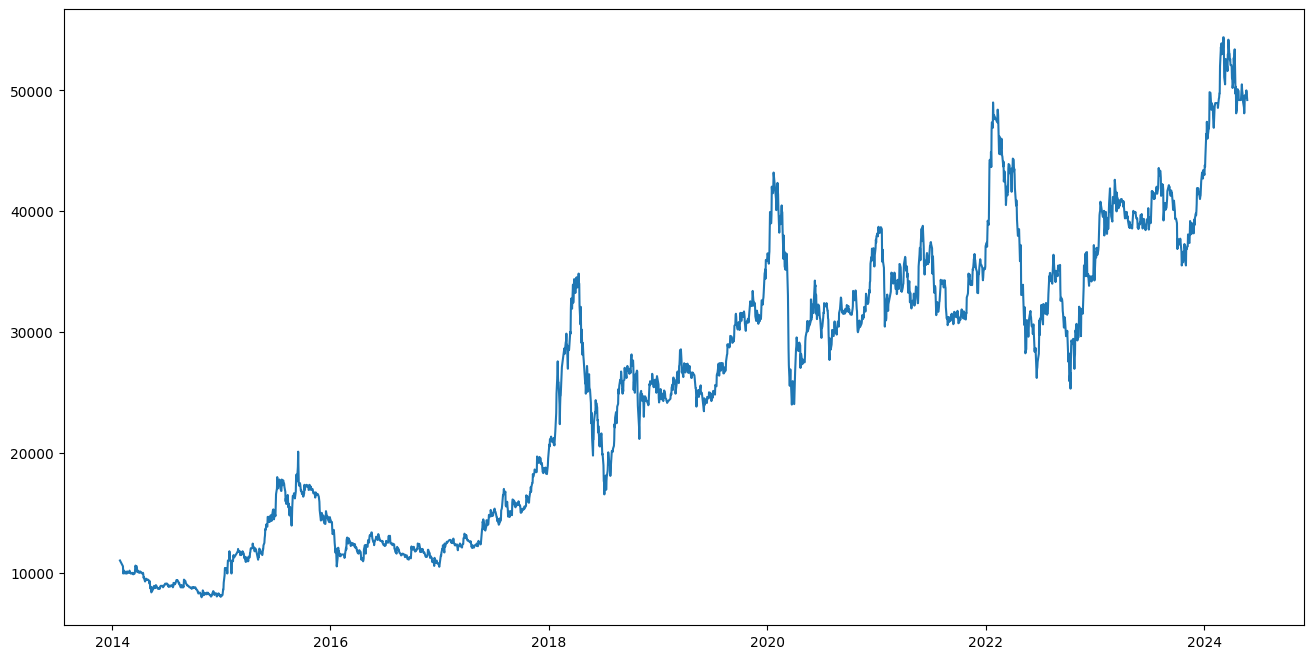

In [41]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

### Sort the dataset on date time and filter “Date” and “Close” columns

In [42]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.tail()

,Date,Close
2567,2024-05-20 00:00:00,49600.0
2568,2024-05-21 00:00:00,50000.0
2569,2024-05-22 00:00:00,49800.0
2570,2024-05-23 00:00:00,49500.0
2571,2024-05-24 00:00:00,49200.0


### Normalize the new filtered dataset

In [43]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_size = int(len(final_dataset) * 0.8)
train_data = final_dataset[:train_size, :]
valid_data = final_dataset[train_size:, :]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


### Build and train the LSTM model

In [44]:
# Define the model
lstm_model = Sequential()

# Add an input layer
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))

# Add LSTM layers
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=50))

# Add Dense layer
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

1997/1997 - 54s - 27ms/step - loss: 0.0017


### Take a sample of a dataset to make stock price predictions using the LSTM model

In [45]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


### Save the LSTM model

In [49]:
lstm_model.save("saved_model.keras")

### Visualize the predicted stock costs with actual stock costs

<ipython-input-47-5c9ca86cff4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


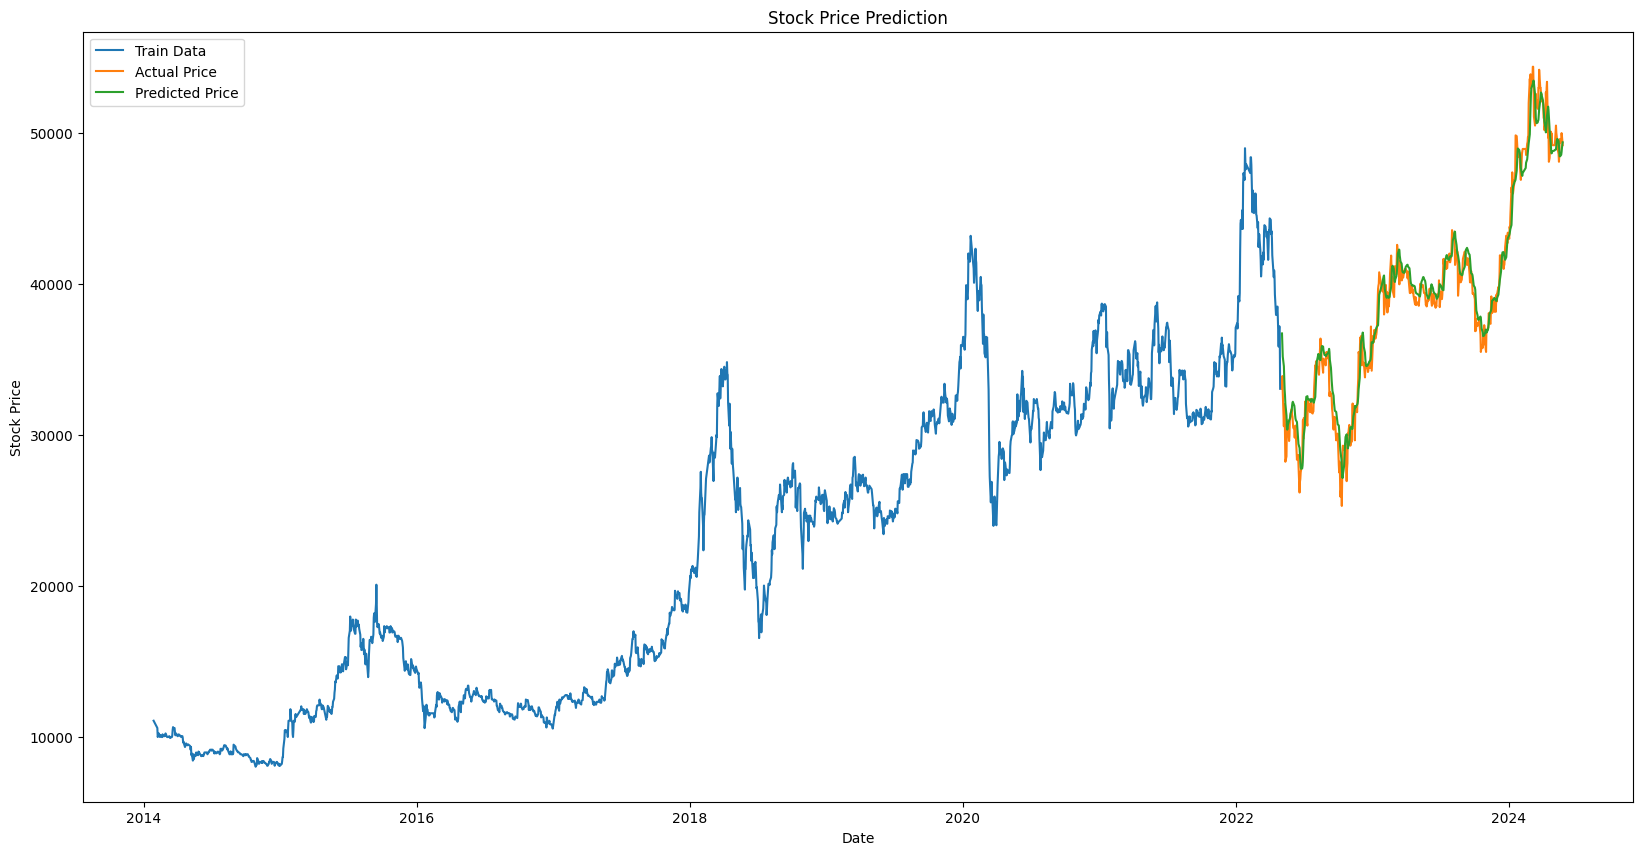

In [47]:
train_data=new_dataset[:train_size]
valid_data=new_dataset[train_size:]
valid_data['Predictions']=predicted_closing_price

plt.plot(train_data["Close"], label='Train Data')
plt.plot(valid_data["Close"], label='Actual Price')
plt.plot(valid_data["Predictions"], label='Predicted Price')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.show()